In [21]:
%matplotlib inline


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
texts = ["The caged bird sings with a fearful trill", 
         "for the caged bird sings of freedom"]
cv = CountVectorizer()
d = cv.fit_transform(texts)
# Create a dataframe of the word counts to inspect
# - d.todense() transforms the dtm into a normal (dense) matrix
# - get_feature_names() is a list of the words
pd.DataFrame(d.todense(), columns=cv.get_feature_names()) 

,bird,caged,fearful,for,freedom,of,sings,the,trill,with
0,1,1,1,0,0,0,1,1,1,1
1,1,1,0,1,1,1,1,1,0,0


In [20]:
import pandas as pd
from nltk.tokenize import TreebankWordTokenizer
sotu = pd.read_csv("http://cssbook.net/d/sotu.csv")
cv = CountVectorizer(tokenizer=TreebankWordTokenizer().tokenize)
d = cv.fit_transform(sotu["text"])
d

<85x22219 sparse matrix of type '<class 'numpy.int64'>'
	with 149567 stored elements in Compressed Sparse Row format>

(-0.5, 399.5, 399.5, -0.5)

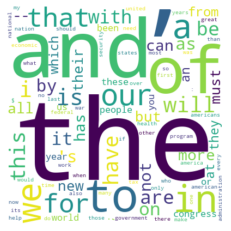

In [26]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
frequencies = d.sum(axis=0).tolist()[0]
freq_dict = {term: n for (term, n) in zip(cv.get_feature_names(), frequencies)}
wc = WordCloud(background_color="white", max_words=100, width=400, height=400)
wc.generate_from_frequencies(freq_dict)
plt.figsize=(20,20)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")